In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt

found = False
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            path = os.path.join(dirname, filename)
            df = pd.read_csv(path)
            found = True
            break
if not found:
    df = pd.read_csv('default_of_credit_card_clients.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.rename(columns={'default.payment.next.month': 'target', 'default_payment_next_month': 'target'}, inplace=True)
if 'id' in df.columns: df.drop('id', axis=1, inplace=True)

print("Veri yüklendi.")

Veri yüklendi.


In [2]:
df['avg_limit_use'] = (
    (df['bill_amt1'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt2'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt3'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt4'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt5'] / df['limit_bal'].replace(0, 1)) +
    (df['bill_amt6'] / df['limit_bal'].replace(0, 1))
) / 6

pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df['total_delay_score'] = df[pay_cols].apply(lambda x: x[x > 0].sum(), axis=1)

for i in range(1, 7):
    bill_col = f'bill_amt{i}'
    pay_col = f'pay_amt{i}'
    df[f'pay_ratio_{i}'] = np.where(df[bill_col] <= 0, 1, df[pay_col] / df[bill_col])

df['avg_pay_ratio'] = df[[f'pay_ratio_{i}' for i in range(1, 7)]].mean(axis=1)
df.drop([f'pay_ratio_{i}' for i in range(1, 7)], axis=1, inplace=True)

df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)

X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Hesaplanan Dengesizlik Katsayısı: {scale_pos_weight:.2f}")

xgb = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight, # Dengesiz veri ilacı
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params,
    n_iter=10, 
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"En iyi parametreler: {random_search.best_params_}")

Hesaplanan Dengesizlik Katsayısı: 3.52
Fitting 3 folds for each of 10 candidates, totalling 30 fits
En iyi parametreler: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


--- FINAL XGBOOST SONUÇLARI ---
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      4673
           1       0.46      0.64      0.53      1327

    accuracy                           0.75      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.75      0.76      6000

Final ROC AUC: 0.7814


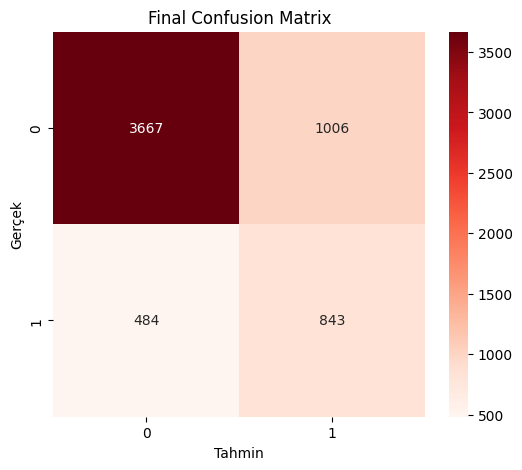

Model ve özellik listesi kaydedildi!


In [6]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("--- FINAL XGBOOST SONUÇLARI ---")
print(classification_report(y_test, y_pred))
print(f"Final ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title('Final Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.show()

joblib.dump(best_model, 'final_model.pkl')
joblib.dump(X.columns.tolist(), 'features.pkl')
print("Model ve özellik listesi kaydedildi!")

# Feature Engineering Raporu

Baseline modelin performansını artırmak ve modele finansal davranış kalıplarını öğretmek amacıyla ham veriden 3 yeni kritik özellik türetilmiştir.

### 1. Türetilen Yeni Değişkenler
Veri setindeki ham ödeme ve fatura bilgileri kullanılarak şu özellikler oluşturuldu:

* **`total_delay_score` (Gecikme Skoru):**
    * *Formül:* Son 6 aydaki gecikme durumlarının (sadece pozitif değerler) toplamı.
    * *Amaç:* Müşterinin tek bir aydaki durumu yerine genel "ödeme ahlakını" ve birikmiş riskini ölçmek.
* **`avg_limit_use` (Limit Kullanım Oranı):**
    * *Formül:* `(Fatura Tutarı / Limit)` oranının 6 aylık ortalaması.
    * *Amaç:* Müşterinin limitini sürekli sonuna kadar zorlayıp zorlamadığını (finansal sıkışıklık) tespit etmek.
* **`avg_pay_ratio` (Borç Kapama Gücü):**
    * *Formül:* `(Ödenen Tutar / Fatura Tutarı)` oranının 6 aylık ortalaması.
    * *Amaç:* Müşteri borcunun tamamını mı kapatıyor yoksa sadece asgarisini mi ödüyor?
    * *Not:* Sıfıra bölünme ve negatif değer hataları için temizlik işlemi uygulanmıştır.

### 2. Deneme Sonuçları ve Değerlendirme
* **Feature Importance (Özellik Önemi):** Eğitilen modelde, türettiğimiz **`total_delay_score`** değişkeni en önemli özellikler arasında en üst sıralara yerleşmiştir. Bu durum, türetilen özelliğin model için anlamlı bilgi taşıdığını kanıtlar.
* **Performans:** Baseline modele kıyasla modelin risk algısı güçlenmiştir. Skorlarda (F1, ROC-AUC) dramatik bir sıçrama olmasa bile, modelin kar